# Прогнозирование конечных свойств новых материалов (композиционных материалов)
Композиционные материалы - это искусственно созданные материалы, состоящие из нескольких других с четкой границей между ними. Композиты обладают теми свойствами, которые не наблюдаются у компонентов по отдельности. При этом композиты являются монолитным материалом, т. е. компоненты материала неотделимы друг от друга без разрушения конструкции в целом. Яркий пример композита - железобетон. Бетон прекрасно сопротивляется сжатию, но плохо растяжению. Стальная арматура внутри бетона компенсирует его неспособность сопротивляться сжатию, формируя тем самым новые, уникальные свойства. Современные композиты изготавливаются из других материалов: полимеры, керамика, стеклянные и углеродные волокна, но данный принцип сохраняется. У такого подхода есть и недостаток: даже если мы знаем характеристики исходных компонентов, определить характеристики композита, состоящего из этих компонентов, достаточно проблематично. Для решения этой проблемы есть два пути: физические испытания образцов материалов, или прогнозирование характеристик. Суть прогнозирования заключается в симуляции представительного элемента объема композита, на основе данных о характеристиках входящих компонентов (связующего и армирующего компонента)

## Требования
1. Изучить теоретические основы и методы решения поставленной задачи.
2. Провести разведочный анализ предложенных данных. Необходимо нарисовать гистограммы распределения каждой из переменной, диаграммы ящика с усами, попарные графики рассеяния точек. Необходимо также для каждой колонке получить среднее, медианное значение, провести анализ и исключение выбросов, проверить наличие пропусков.
3. Провести предобработку данных (удаление шумов, нормализация и т.д.).
4. Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении. При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей. При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.
5. Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель.
6. Разработать приложение с графическим интерфейсом или интерфейсом командной строки, которое будет выдавать прогноз, полученный в задании 4 или 5 (один или два прогноза, на выбор учащегося).
7. Оценить точность модели на тренировочном и тестовом датасете. 
8. Создать репозиторий в GitHub / GitLab и разместить там код исследования. Оформить файл README.

## Импорты

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import scipy.stats as stats
from joblib import dump, load

## Загрузить и объединить датасет

### Загрузка данных

In [3]:
X_bp = pd.read_excel(
    'https://github.com/ritulupov/BKP/blob/main/data/X_bp.xlsx?raw=true',
     index_col=0, engine='openpyxl')

X_nup = pd.read_excel(
    'https://github.com/ritulupov/BKP/blob/main/data/X_nup.xlsx?raw=true',
     index_col=0, engine='openpyxl')

In [4]:
X_bp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
dtypes: float64(10)
memory usage: 87.9 KB


Есть 10 колонок тип данных float64. Строк 1024, пропусков нет.

In [5]:
X_nup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 0 to 1039
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Угол нашивки, град  1040 non-null   int64  
 1   Шаг нашивки         1040 non-null   float64
 2   Плотность нашивки   1040 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 32.5 KB


Есть 3 колонки. 1 - int, 2 - float64. Строк 1040, пропусков нет.

### Объединение по индексу тип объединения INNER

In [6]:
full_df = X_bp.join(X_nup)

In [7]:
full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.0,2.930366,0.913222,0.389403,2.317887,2.906878,3.552660,5.591742
"Плотность, кг/м3",1023.0,1975.734888,73.729231,1731.764635,1924.155467,1977.621657,2021.374375,2207.773481
"модуль упругости, ГПа",1023.0,739.923233,330.231581,2.436909,500.047452,739.664328,961.812526,1911.536477
"Количество отвердителя, м.%",1023.0,110.570769,28.295911,17.740275,92.443497,110.564840,129.730366,198.953207
"Содержание эпоксидных групп,%_2",1023.0,22.244390,2.406301,14.254985,20.608034,22.230744,23.961934,33.000000
"Температура вспышки, С_2",1023.0,285.882151,40.943260,100.000000,259.066528,285.896812,313.002106,413.273418
"Поверхностная плотность, г/м2",1023.0,482.731833,281.314690,0.603740,266.816645,451.864365,693.225017,1399.542362
"Модуль упругости при растяжении, ГПа",1023.0,73.328571,3.118983,64.054061,71.245018,73.268805,75.356612,82.682051
"Прочность при растяжении, МПа",1023.0,2466.922843,485.628006,1036.856605,2135.850448,2459.524526,2767.193119,3848.436732
"Потребление смолы, г/м2",1023.0,218.423144,59.735931,33.803026,179.627520,219.198882,257.481724,414.590628


In [8]:
full_df.to_excel('full_df.xlsx')

In [9]:
drop_cols = ['Плотность, кг/м3',
             'модуль упругости, ГПа',
             'Поверхностная плотность, г/м2'
             ]
targ_cols = [
             'Соотношение матрица-наполнитель'
             ]
# 'Модуль упругости при растяжении, ГПа',
#             'Прочность при растяжении, МПа',

In [10]:
est_df = pd.DataFrame()  # таблица с оценками моделей

In [11]:
cur_target_cols=['Соотношение матрица-наполнитель']  # целевые колонки


## Функции

In [12]:
def hisboxplt(data, ncols=1):
    """
    Рисует комбинированные графики histplot и boxplot по ncols колонок
    """
    if len(data.shape) == 1:
        num_cols = 1
    else:
        num_cols = data.shape[1]
    if ncols > num_cols:
        ncols = num_cols
    spec = mpl.gridspec.GridSpec(ncols=ncols, nrows=num_cols * 2,
                                 height_ratios=[1, 4] * num_cols, hspace=0.55)
    fig = plt.figure(figsize=(18, (num_cols // ncols) * 20))
    i, j = -1, -1
    for l in range(num_cols):
        j += 1
        if not l % ncols:
            j = 0
            i += 1
        ax = fig.add_subplot(spec[2 * ncols * i + j])
        sns.boxplot(data=data, x=data.columns[ncols * i + j],
                    palette='Set2', ax=ax).set(xlabel=None)
        ax = fig.add_subplot(spec[2 * ncols * i + j + ncols])
        sns.histplot(x=data.columns[ncols * i + j], kde=True,
                     ax=ax, data=data, stat='probability').set(ylabel=None)
    plt.show()

### При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей.

In [13]:
def tt_split(data,
             c_targ_cols_ls=cur_target_cols,
             targ_cols_ls=targ_cols,
             transformer=None,
             nn=False):
    """
    Разбивает выборку по заданым правилам
    """    
    y = data[c_targ_cols_ls]
    X = data.drop(targ_cols_ls, axis=1)
    
    if transformer != None:
      X = transformer.fit_transform(X)
    else:
      X = np.array(X)

    y = np.array(y)
       
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.3, random_state = 42)
    
    if nn:
      y_train = y_train.reshape(-1, 1)
      y_test = y_test.reshape(-1, 1)
    else:
      y_train = y_train.ravel()
      y_test = y_test.ravel()    
    return X_train, X_test, y_train, y_test

### Функция для сводной оценки

In [14]:
def est(note, model, data,
        prt=False, drw=False, transformer=None):
    """
    Разбивает данные, обучает модель.
    Рисует тестовые и предсказанные значения (ожидается прямая y = x)
    Возвращает (и печатает) DataFrame с примечанием и оценками
    """
    X_train, X_test, y_train, y_test = tt_split(
        data, transformer=transformer
        )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    note = str(data.shape[0]) + ' ' + str(transformer) + ' ' + str(model) + note
    res = {'note': note,
           'r2': r2_score(y_test, y_pred),
           'MAE': mean_absolute_error(y_test, y_pred),
           'MSE': mean_squared_error(y_test, y_pred),
           }    
    res['params'] = [model]
    res['transf'] = [transformer]
    
    # отрисовываем результат предсказания модели поверх тестовых данных
    if drw:
      plt.figure(figsize = (7, 5))
      plt.scatter(y_test, y_test, color='black')
      plt.scatter(y_test, y_pred, color='green')
      plt.title(note)
      plt.show()
      print()

    if prt:
        for k, v in res.items():
            print(k.rjust(6) + ':', v)
    return pd.DataFrame(res)

### Функции для исключения выбросов

In [15]:
def method_3s(data):
    """ 
    Удаляет выбросы по методу трех сигм
    """
    #import scipy.stats as stats
    # абсолютное значение z-score для каждого наблюдения
    z = np.abs(stats.zscore(data))
    
    # сохраняет строки с разбросом меньше 3 сигм
    return data[(z<3).all(axis=1)]

In [16]:
def method_iq(data):
    """ 
    Удаляет выбросы по методу межквартильных расстояний
    """
    #import scipy.stats as stats
    # найти Q1, Q3 и межквартильный диапазон для каждого столбца
    Q1 = data.quantile(q=.25)
    Q3 = data.quantile(q=.75)
    IQR = data.apply(stats.iqr)

    # сохраняет строки со значения в пределах 1,5 * IQR от Q1 и Q3
    return data[
        ~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)
        ]

### Функция для бучения и оценки

In [17]:
def scattgird(data, ncols=4):
    """
    Рисует серию точечных графиков
    """
    l = data.shape[1] - 2
    if ncols <1: ncols = 1
    if l < 1: l = 1
    nrows = int(np.ceil(l / ncols))

    fig = plt.figure(figsize=(3 * ncols, 4 * nrows))
    f = 'mean_test_score'

    for c in range(1, l + 1):
        if not (c - 1) % ncols:
            f = 'mean_test_score'
        sns.set(font_scale = 2/3)
        ax = fig.add_subplot(nrows, ncols, c)
        sns.scatterplot(data=data, ax=ax , legend=False,
                        x=data.columns[c - 1],
                        y='mean_test_score', 
                        hue='rank_test_score').set(ylabel=f)
        f = None
    plt.show()

In [18]:
def rs_viz(model, data, param_distr, transformer=None, ncols=3):
    """
    Визуализация случайного поиска гиперпараметров
     
    """

    rs = RandomizedSearchCV(
        model, n_iter = 33, cv = 6, n_jobs=-1,
        random_state=32, scoring='r2',
        param_distributions=param_distr
        )

    X_train, X_test, y_train, y_test = tt_split(
        data,transformer=transformer)

    rs.fit(X_train, y_train)

    ls = ['param_' + i for i in param_distr]
    ls.append('rank_test_score')
    ls.append('mean_test_score')

    # дата фрейм с результатами случайного поиска гиперпараметров
    rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')
    rs_df = rs_df[ls]
    rs_df.reset_index(drop=True)

    # визуализация 'split2_test_score',
    scattgird(rs_df, ncols)
    
    return pd.DataFrame(est(' RndSearch', rs.best_estimator_, data,
                            transformer=transformer)), rs_df


## Разведочный анализ

In [19]:
work_df = full_df.copy()

### Удаляю дубликаты

In [20]:
work_df.shape

(1023, 13)

In [21]:
work_df = work_df.drop_duplicates()
work_df.shape

(1023, 13)

Дубликатов нет

### Обработка пропусков

In [22]:
work_df.isnull().mean() * 100

Соотношение матрица-наполнитель         0.0
Плотность, кг/м3                        0.0
модуль упругости, ГПа                   0.0
Количество отвердителя, м.%             0.0
Содержание эпоксидных групп,%_2         0.0
Температура вспышки, С_2                0.0
Поверхностная плотность, г/м2           0.0
Модуль упругости при растяжении, ГПа    0.0
Прочность при растяжении, МПа           0.0
Потребление смолы, г/м2                 0.0
Угол нашивки, град                      0.0
Шаг нашивки                             0.0
Плотность нашивки                       0.0
dtype: float64

Пропусков нет

### Гистограммы распределения каждой из переменной, диаграммы ящик с усами
график распределения признака 'Поверхностная плотность, г/м2' сдвинут влево, серьезных выбросов нет.

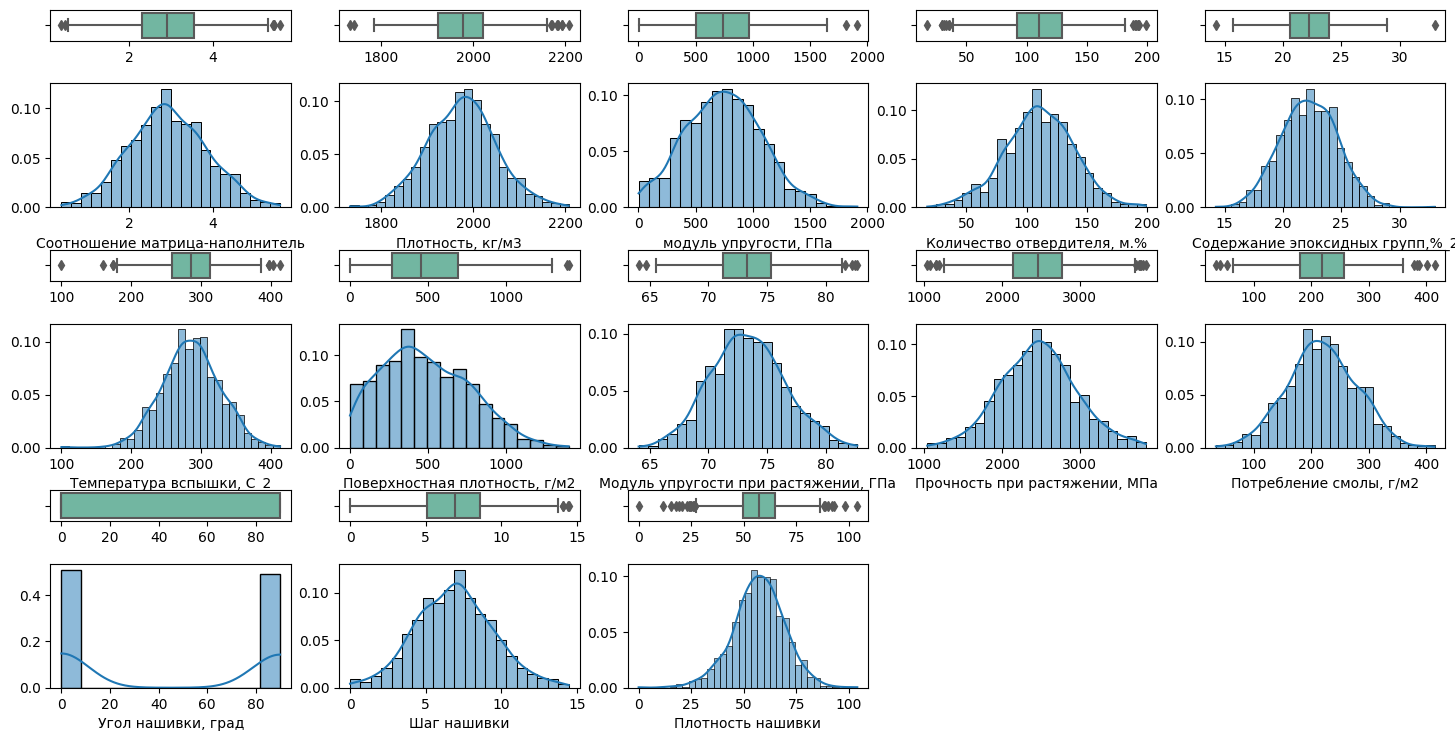

In [23]:
hisboxplt(work_df, 5)

### Есть два распространенных способа удалить выбросы метод межквартильного диапазона и метод трех сигм

метод межквартильного диапазона

In [24]:
work_df.shape[0] - method_iq(work_df).shape[0]

87

 метод трех сигм

In [25]:
work_df.shape[0] - method_3s(work_df).shape[0]

24

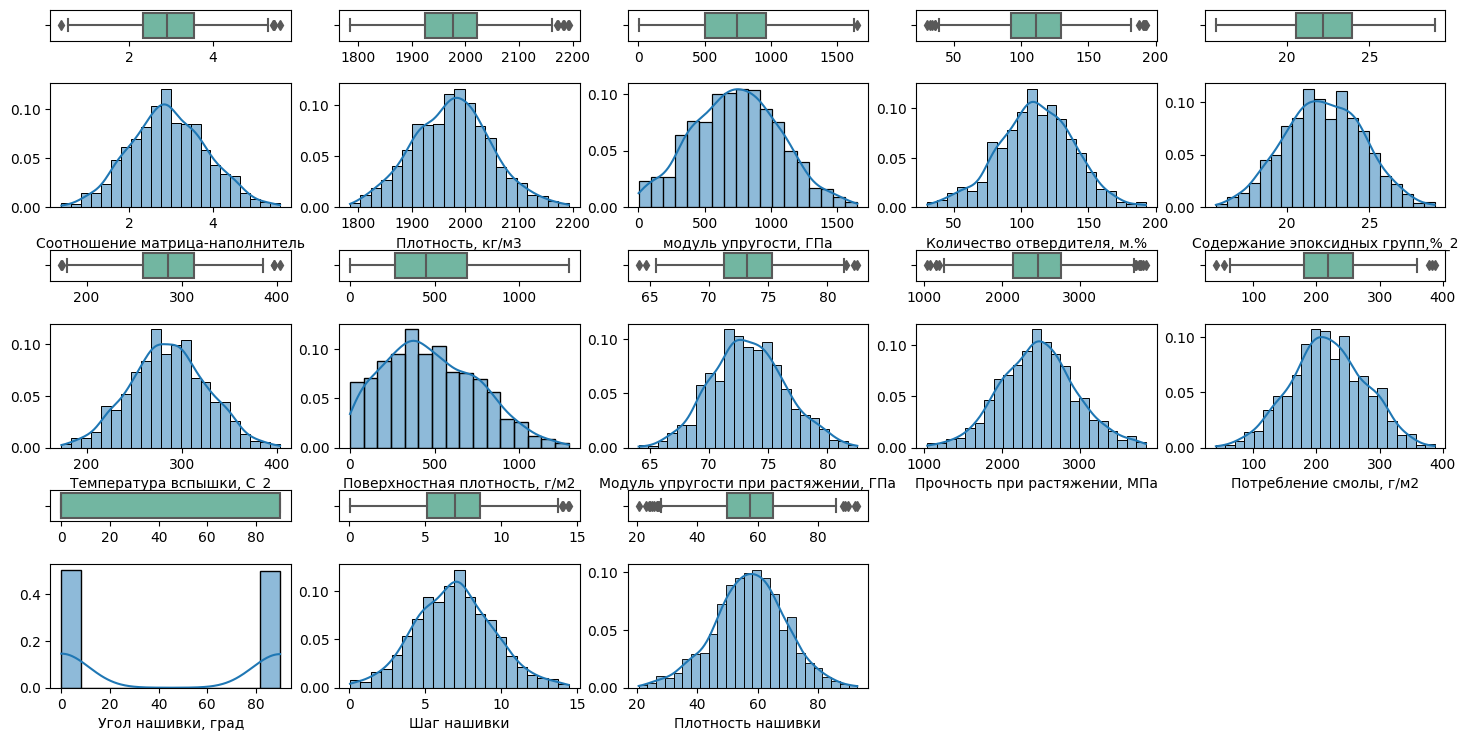

In [26]:
hisboxplt(method_3s(work_df), 5)

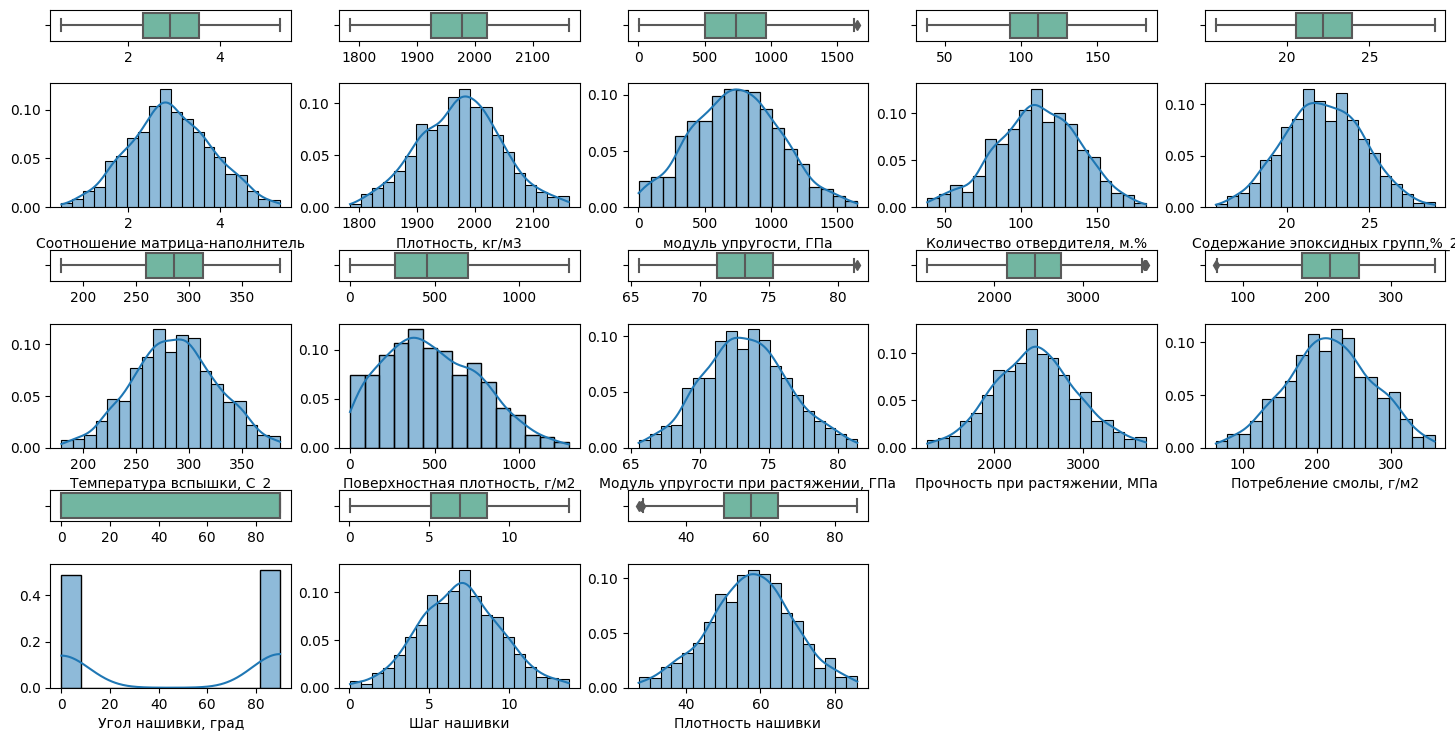

In [27]:
hisboxplt(method_iq(work_df), 5)

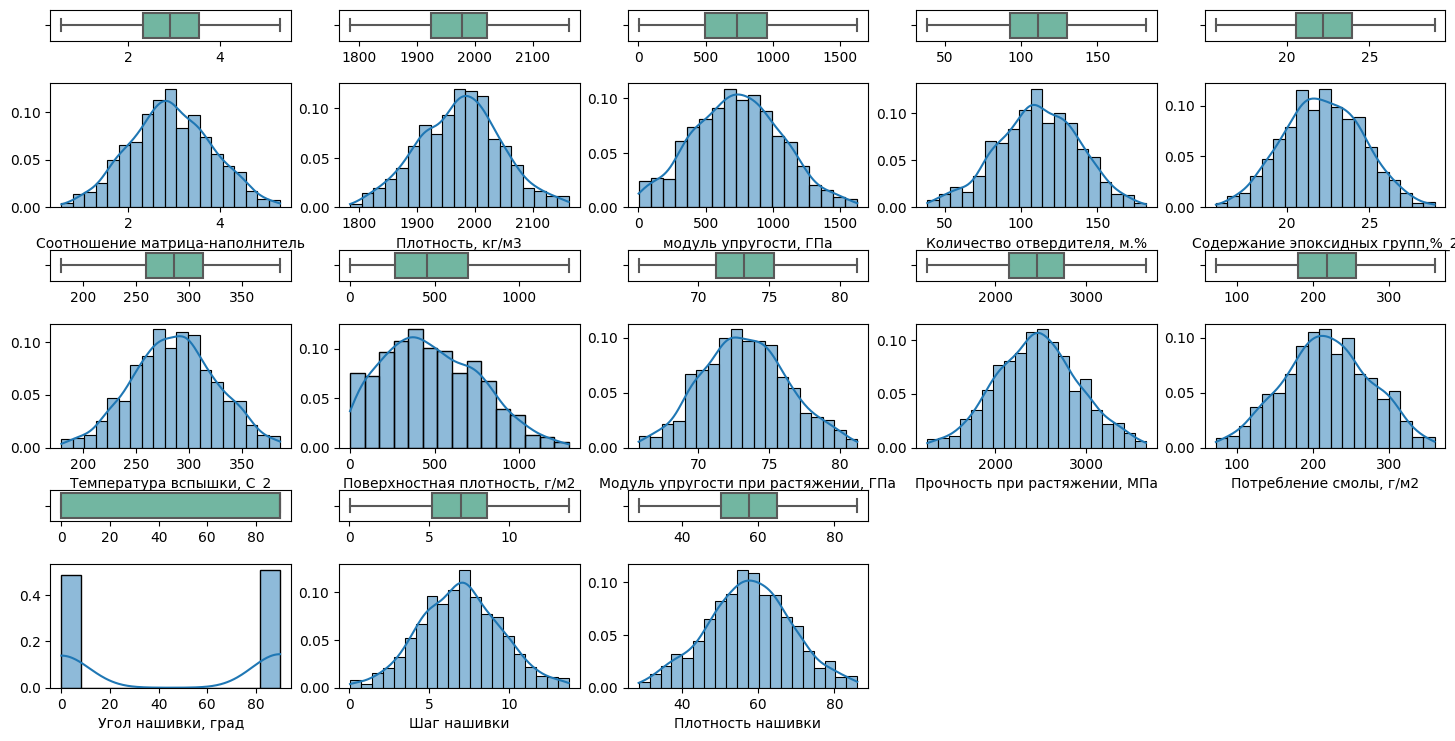

In [28]:
hisboxplt(method_iq(method_iq(method_iq(work_df))), 5)

In [29]:
clean_df = method_iq(method_iq(method_iq(work_df)))
clean_df.shape

(922, 13)

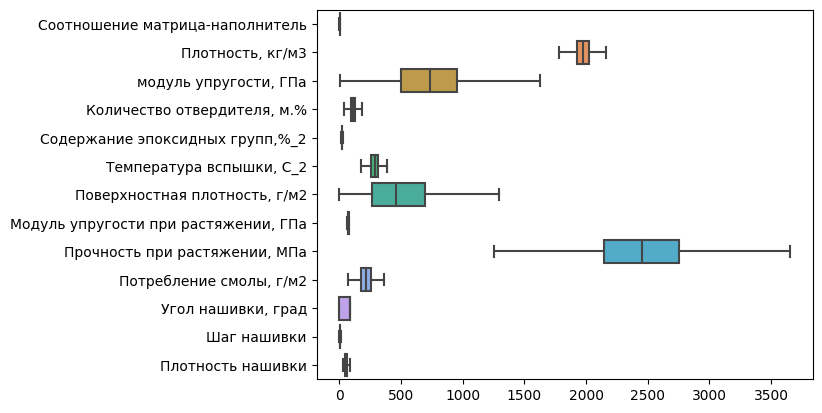

In [30]:
sns.boxplot(data = clean_df, orient="h")
plt.show()

### Тепловая карта корреляций
Никаких сильных корреляций нет.

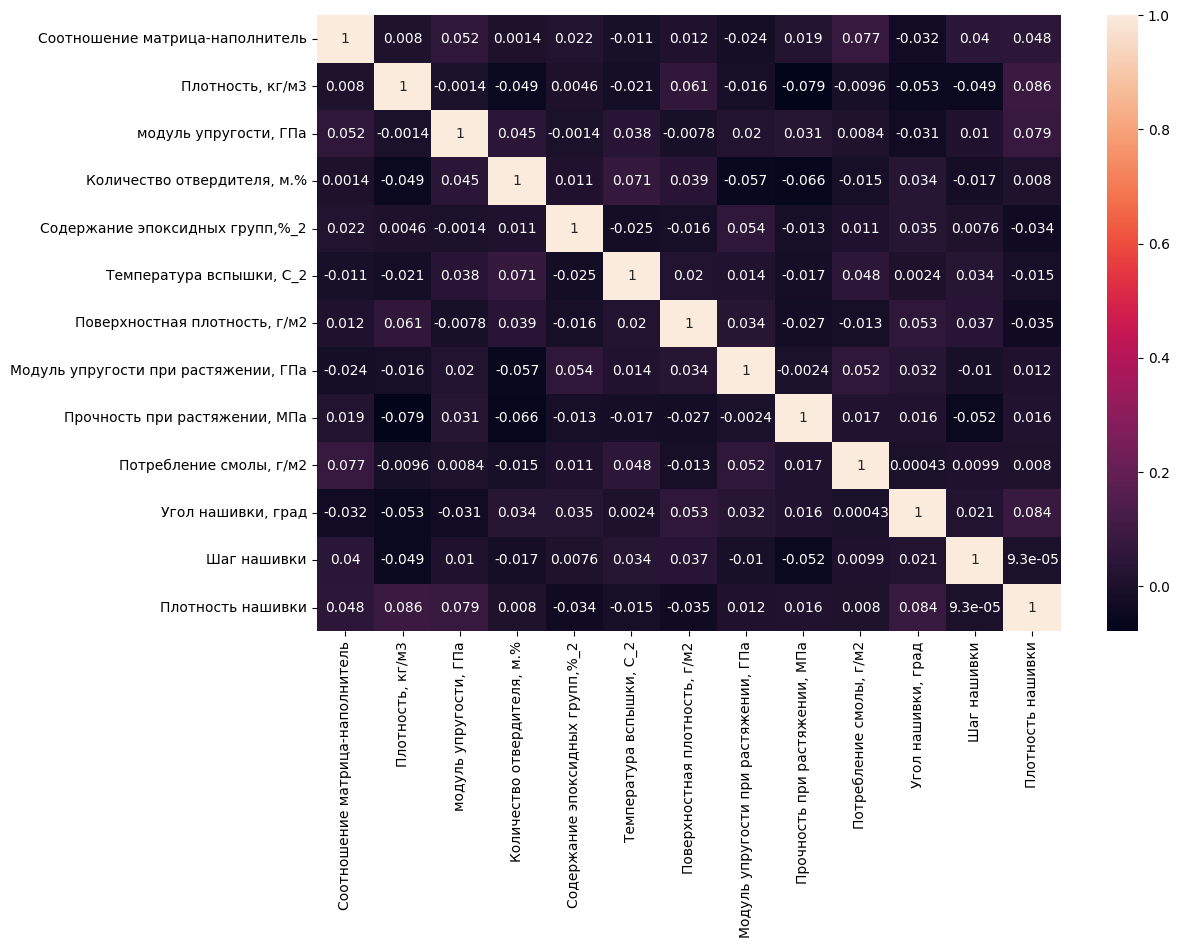

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(clean_df.corr(), annot=True, )
plt.show()

### Попарные графики рассеяния точек
По-прежнему ничего похожего на линейные зависимости нет. Серьезных выбросов не видно.


In [32]:
sns.pairplot(clean_df)

Output hidden; open in https://colab.research.google.com to view.

### Среднее, медианное значение для каждой колонки

In [33]:
clean_df.describe().loc[['mean', '50%']].T

,mean,50%
Соотношение матрица-наполнитель,2.927964,2.907832
"Плотность, кг/м3",1974.118744,1977.321002
"модуль упругости, ГПа",736.119982,736.178435
"Количество отвердителя, м.%",111.136066,111.162090
"Содержание эпоксидных групп,%_2",22.200570,22.177681
"Температура вспышки, С_2",286.181128,286.220763
"Поверхностная плотность, г/м2",482.429070,457.732246
"Модуль упругости при растяжении, ГПа",73.303464,73.247594
"Прочность при растяжении, МПа",2461.491315,2455.974462
"Потребление смолы, г/м2",218.048059,218.697660


In [34]:
clean_df.median() / full_df.mean() * 100

Соотношение матрица-наполнитель          99.231033
Плотность, кг/м3                        100.080280
модуль упругости, ГПа                    99.493894
Количество отвердителя, м.%             100.534790
Содержание эпоксидных групп,%_2          99.700109
Температура вспышки, С_2                100.118445
Поверхностная плотность, г/м2            94.821227
Модуль упругости при растяжении, ГПа     99.889570
Прочность при растяжении, МПа            99.556193
Потребление смолы, г/м2                 100.125681
Угол нашивки, град                      203.379722
Шаг нашивки                             101.067364
Плотность нашивки                       100.752871
dtype: float64

Поверхностная плотность, г/м2: **94.821227**

## Предобработка данных

### Извлечение корня делает распределение визуально правильнее


In [35]:
sqrt_df = clean_df.copy()
sqrt_df['Поверхностная плотность, г/м2'] = np.sqrt(sqrt_df['Поверхностная плотность, г/м2'])


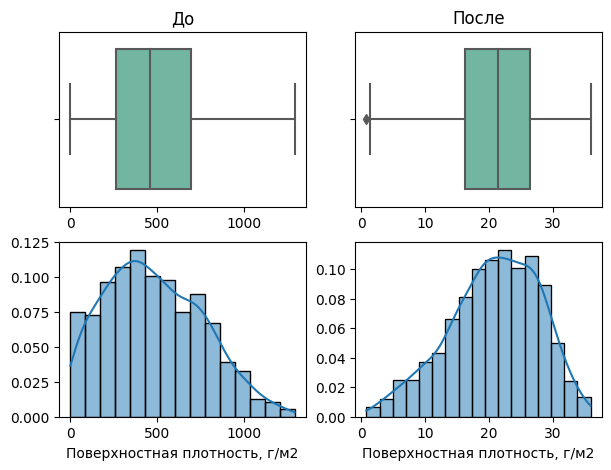

In [36]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(2, 2, 2)
sns.boxplot(data=sqrt_df, x=sqrt_df['Поверхностная плотность, г/м2'],
            palette='Set2', ax=ax).set(xlabel=None, title='После')
ax = fig.add_subplot(2, 2, 4)
sns.histplot(x=sqrt_df['Поверхностная плотность, г/м2'],
             kde=True, ax=ax, data=sqrt_df, stat='probability').set(ylabel=None)
ax = fig.add_subplot(2, 2, 1)
sns.boxplot(data=clean_df, x=clean_df['Поверхностная плотность, г/м2'],
            palette='Set2', ax=ax).set(xlabel=None, title='До')
ax = fig.add_subplot(2, 2, 3)
sns.histplot(x=clean_df['Поверхностная плотность, г/м2'],
             kde=True, ax=ax, data=clean_df, stat='probability').set(ylabel=None)
plt.show()

Появился выброс. Удаляю

In [37]:
clean_df = method_iq(sqrt_df)
clean_df.shape

(921, 13)

### Нормализация

Оценка плотности ядра

In [38]:
X_df = clean_df.copy().drop(targ_cols, axis=1)

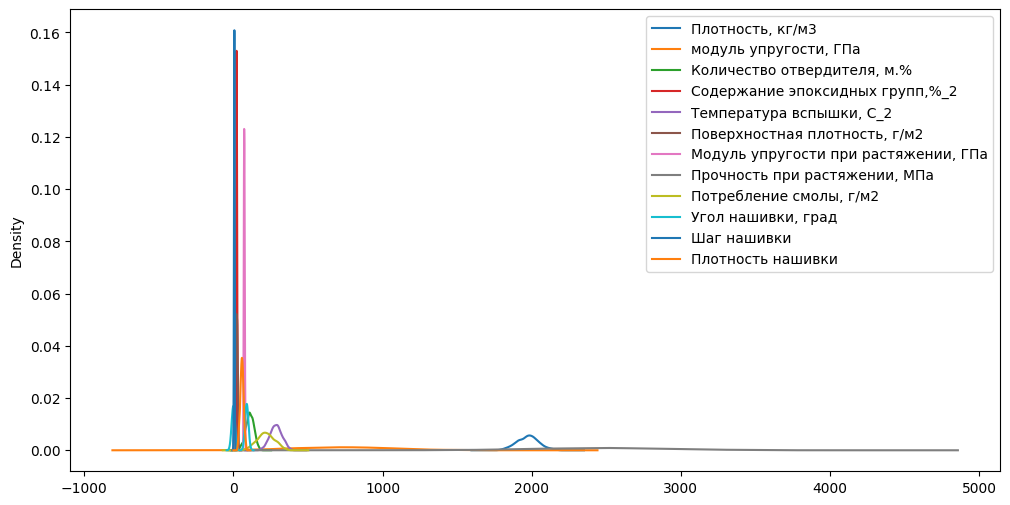

                                              max          min
Плотность, кг/м3                      2161.565216  1784.482245
модуль упругости, ГПа                 1628.000000     2.436909
Количество отвердителя, м.%            181.828448    38.668500
Содержание эпоксидных групп,%_2         28.955094    15.695894
Температура вспышки, С_2               386.067992   179.374391
Поверхностная плотность, г/м2           35.935221     1.291512
Модуль упругости при растяжении, ГПа    81.203147    65.793845
Прочность при растяжении, МПа         3654.434359  1250.392802
Потребление смолы, г/м2                359.052220    72.530873
Угол нашивки, град                      90.000000     0.000000
Шаг нашивки                             13.732404     0.037639
Плотность нашивки                       86.012427    28.661632


In [39]:
fig, ax = plt.subplots(figsize = (12, 6))
X_df.plot(kind = 'kde', ax = ax)
plt.show()
print(X_df.describe().loc[['max', 'min']].T)

Как и было замечено ранее данные имеют разный масштаб. Требуется нормализазия

MinMaxScaler

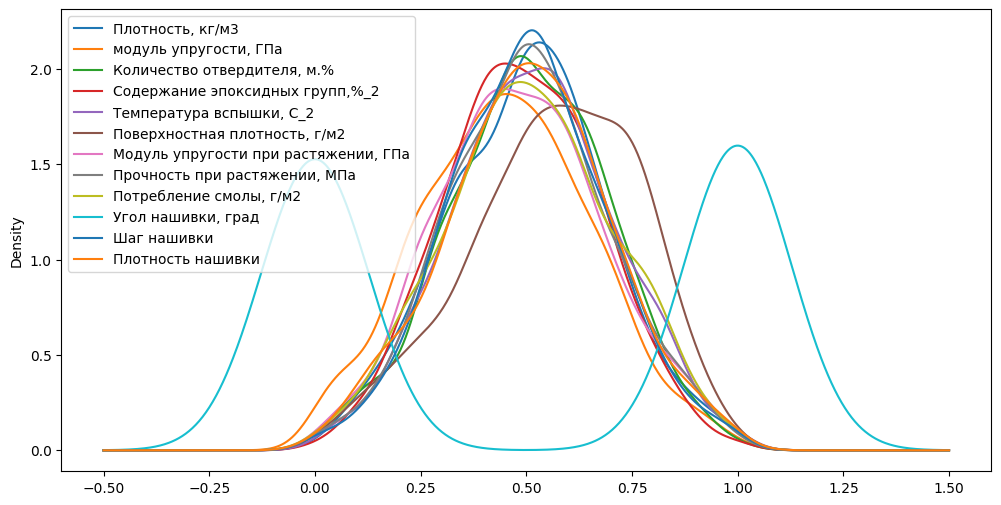

                                      max  min
Плотность, кг/м3                      1.0  0.0
модуль упругости, ГПа                 1.0  0.0
Количество отвердителя, м.%           1.0  0.0
Содержание эпоксидных групп,%_2       1.0  0.0
Температура вспышки, С_2              1.0  0.0
Поверхностная плотность, г/м2         1.0  0.0
Модуль упругости при растяжении, ГПа  1.0  0.0
Прочность при растяжении, МПа         1.0  0.0
Потребление смолы, г/м2               1.0  0.0
Угол нашивки, град                    1.0  0.0
Шаг нашивки                           1.0  0.0
Плотность нашивки                     1.0  0.0


In [40]:
scaler = MinMaxScaler()
scaler.fit(X_df)
test_df = pd.DataFrame(scaler.transform(X_df), columns=X_df.columns)
fig, ax = plt.subplots(figsize = (12, 6))
test_df.plot(kind = 'kde', ax = ax)
plt.show()
print(test_df.describe().loc[['max', 'min']].T)

StandardScaler

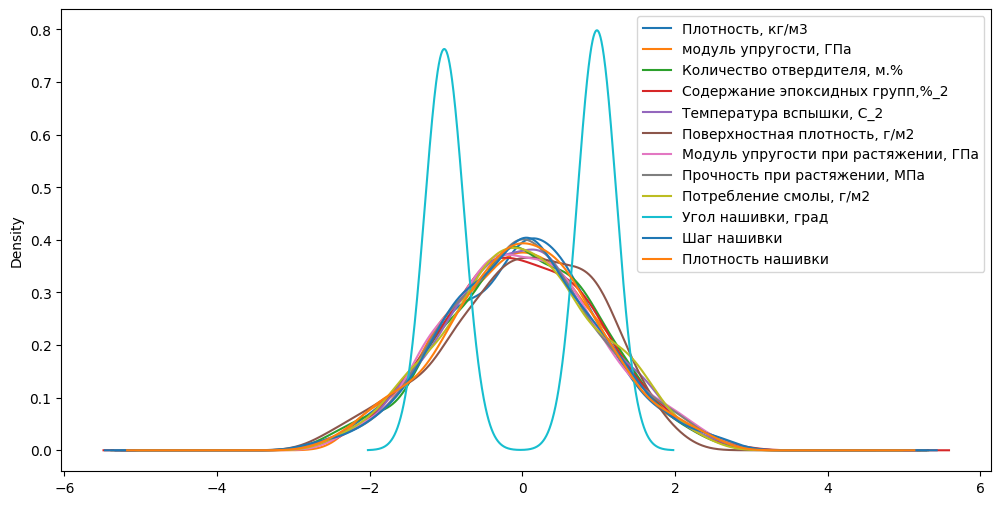

                                           max       min
Плотность, кг/м3                      2.638375 -2.670005
модуль упругости, ГПа                 2.724160 -2.243963
Количество отвердителя, м.%           2.642366 -2.708763
Содержание эпоксидных групп,%_2       2.821362 -2.718041
Температура вспышки, С_2              2.538190 -2.710834
Поверхностная плотность, г/м2         2.152936 -2.783296
Модуль упругости при растяжении, ГПа  2.610512 -2.482422
Прочность при растяжении, МПа         2.632521 -2.676357
Потребление смолы, г/м2               2.470436 -2.547182
Угол нашивки, град                    0.977453 -1.023067
Шаг нашивки                           2.704921 -2.744008
Плотность нашивки                     2.557817 -2.599938


In [41]:
scaler = StandardScaler()
scaler.fit(X_df)
test_df = pd.DataFrame(scaler.transform(X_df), columns=X_df.columns)
fig, ax = plt.subplots(figsize = (12, 6))
test_df.plot(kind = 'kde', ax = ax)
plt.show()
print(test_df.describe().loc[['max', 'min']].T)

Normalizer

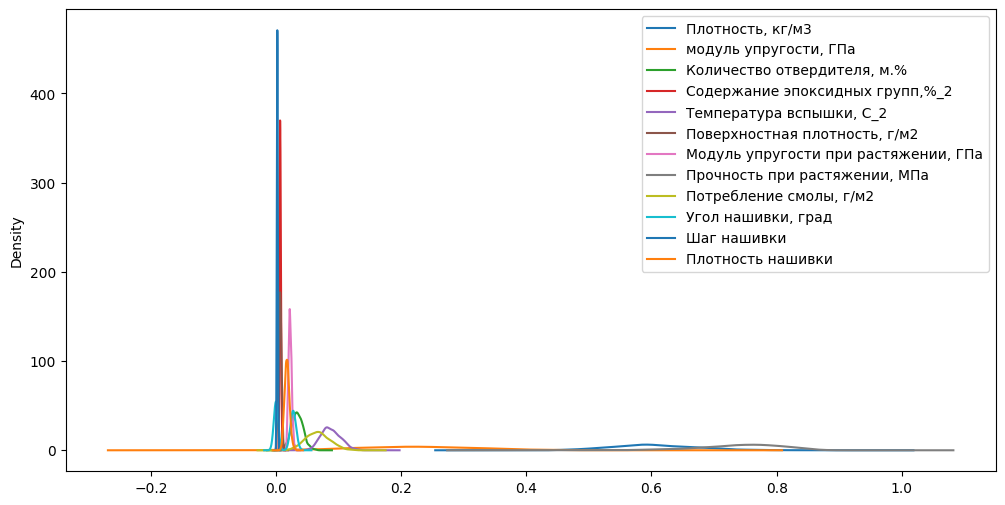

                                           max       min
Плотность, кг/м3                      0.827568  0.445482
модуль упругости, ГПа                 0.539366  0.000724
Количество отвердителя, м.%           0.063397  0.011531
Содержание эпоксидных групп,%_2       0.010879  0.004284
Температура вспышки, С_2              0.148559  0.050793
Поверхностная плотность, г/м2         0.012996  0.000452
Модуль упругости при растяжении, ГПа  0.030988  0.016307
Прочность при растяжении, МПа         0.880199  0.475718
Потребление смолы, г/м2               0.123983  0.021723
Угол нашивки, град                    0.037721  0.000000
Шаг нашивки                           0.004759  0.000011
Плотность нашивки                     0.030905  0.007277


In [42]:
scaler = Normalizer()
scaler.fit(X_df)
test_df = pd.DataFrame(scaler.transform(X_df), columns=X_df.columns)
fig, ax = plt.subplots(figsize = (12, 6))
test_df.plot(kind = 'kde', ax = ax)
plt.show()
print(test_df.describe().loc[['max', 'min']].T)

In [43]:
pd.set_option('max_colwidth', 60)# 50
pd.set_option('display.width', 90)# 80

In [44]:
norm_ls = [None, MinMaxScaler(), StandardScaler(), Normalizer()]
model_ls = [LinearRegression(), SVR(), RandomForestRegressor(), GradientBoostingRegressor(), Lasso()]
data_ls = [clean_df, work_df]

In [45]:
est_df = pd.DataFrame()
for i in norm_ls:
  for j in model_ls:
    for k in data_ls:
      est_df =  pd.concat([est_df, est('   default', j, k, transformer=i)],
                                       axis=0, ignore_index=True)


In [46]:
print(est_df.drop([
    'params', 'transf', 'MSE'
    ], axis=1).sort_values(by='r2', ascending=False))

                                                           note        r2       MAE
39                          1023 Normalizer() Lasso()   default -0.001060  0.752221
29                      1023 StandardScaler() Lasso()   default -0.001060  0.752221
19                        1023 MinMaxScaler() Lasso()   default -0.001060  0.752221
9                                   1023 None Lasso()   default -0.003860  0.753861
18                         921 MinMaxScaler() Lasso()   default -0.004001  0.719743
38                           921 Normalizer() Lasso()   default -0.004001  0.719743
28                       921 StandardScaler() Lasso()   default -0.004001  0.719743
8                                    921 None Lasso()   default -0.006118  0.723989
25      1023 StandardScaler() RandomForestRegressor()   default -0.006532  0.763735
3                                     1023 None SVR()   default -0.016033  0.762796
33                            1023 Normalizer() SVR()   default -0.017956  0

Lasso MinMaxScaler на не очищенном датасете r2 = 0.009025 - лучший результат.
LinearRegression с выбросами r2 = 0.005997 StandardScaler и MinMaxScaler на результат не повлияли он такой же, как и вообще без препроцессинга, Normalizer результат ухудшил.
SVR лучше отработал на чистом датасете без выбросов в связке с StandardScaler r2 = 0.000226
RandomForestRegressor StandardScaler на не очищенном датасете r2 = -0.013995
GradientBoostingRegressor MinMaxScaler на не очищенном датасете r2 = -0.040548
Продолжу работу свыше перечисленными конфигурациями.



## Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении.

### Предварительная оценка выбранных моделей

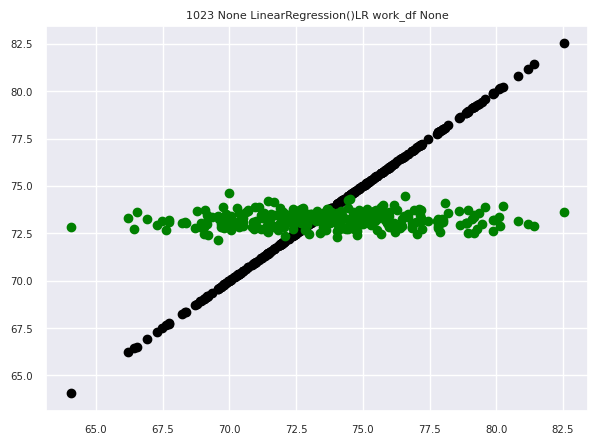


  note: 1023 None LinearRegression()LR work_df None
    r2: -0.018617746813289537
   MAE: 2.560394463652812
   MSE: 10.11937897507892
params: [LinearRegression()]
transf: [None]


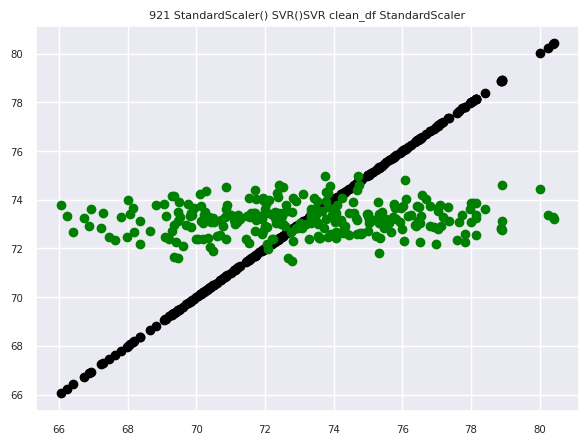


  note: 921 StandardScaler() SVR()SVR clean_df StandardScaler
    r2: -0.0025327034625293177
   MAE: 2.4626762559506195
   MSE: 9.054744982638963
params: [SVR()]
transf: [StandardScaler()]


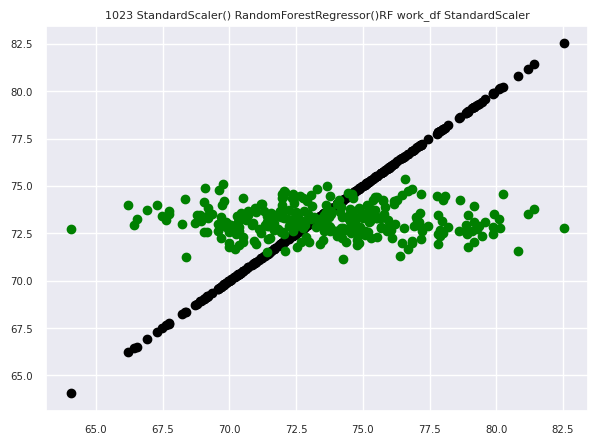


  note: 1023 StandardScaler() RandomForestRegressor()RF work_df StandardScaler
    r2: -0.10538347060033315
   MAE: 2.6451233097407543
   MSE: 10.981346326222129
params: [RandomForestRegressor()]
transf: [StandardScaler()]


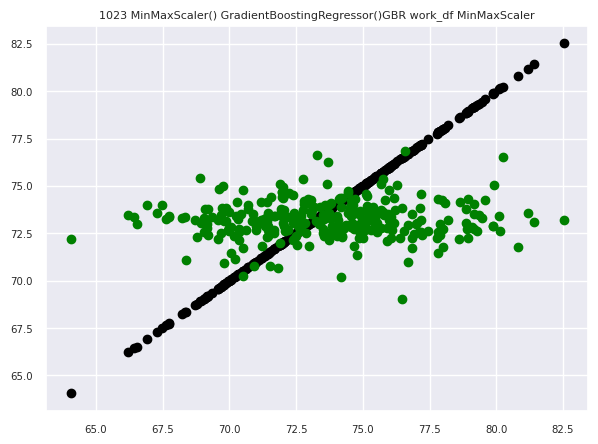


  note: 1023 MinMaxScaler() GradientBoostingRegressor()GBR work_df MinMaxScaler
    r2: -0.0869509348301658
   MAE: 2.6164037158501996
   MSE: 10.798229729723039
params: [GradientBoostingRegressor()]
transf: [MinMaxScaler()]


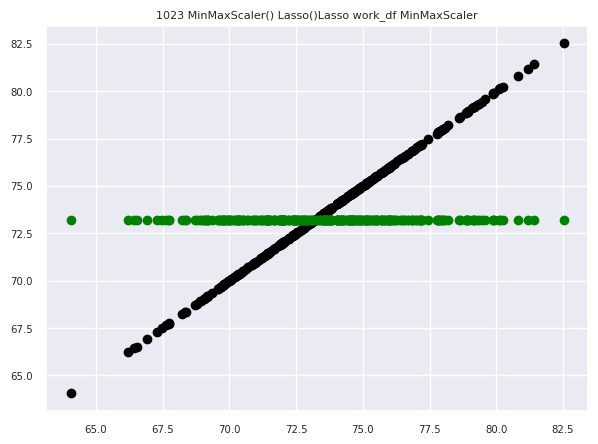


  note: 1023 MinMaxScaler() Lasso()Lasso work_df MinMaxScaler
    r2: -0.016425516980081545
   MAE: 2.5564174362357828
   MSE: 10.097600437887607
params: [Lasso()]
transf: [MinMaxScaler()]


,note,r2,MAE,MSE,params,transf
0,1023 MinMaxScaler() Lasso()Lasso work_df MinMaxScaler,-0.016426,2.556417,10.0976,Lasso(),MinMaxScaler()


In [176]:
# Линейная регрессия
est('LR work_df None',LinearRegression(), work_df, drw=True, prt=True)

# Метод опорных векторов
est('SVR clean_df StandardScaler',SVR(), clean_df,
    drw=True, prt=True, transformer=StandardScaler())

# Случайный лес
est('RF work_df StandardScaler', RandomForestRegressor(), work_df,
    drw=True, prt=True, transformer=StandardScaler())

# Градиентный бустинг
est('GBR work_df MinMaxScaler', GradientBoostingRegressor(), work_df,
    drw=True, prt=True, transformer=MinMaxScaler())

# Лассо регрессор
est('Lasso work_df MinMaxScaler', Lasso(), work_df,
    drw=True, prt=True, transformer=MinMaxScaler())

Результат стабильно отвратительный, но не надо отчаиваться.

### При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.

### RandomForestRegressor
* n_estimators — число «деревьев» в «случайном лесу».
* max_features — число признаков для выбора расщепления.
* max_depth — максимальная глубина деревьев.
* min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
* min_samples_leaf — минимальное число объектов в листьях.
* bootstrap — использование для построения деревьев подвыборки с возвращением.


In [177]:
est_default = est_df.copy()
est_df = pd.DataFrame()

In [178]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

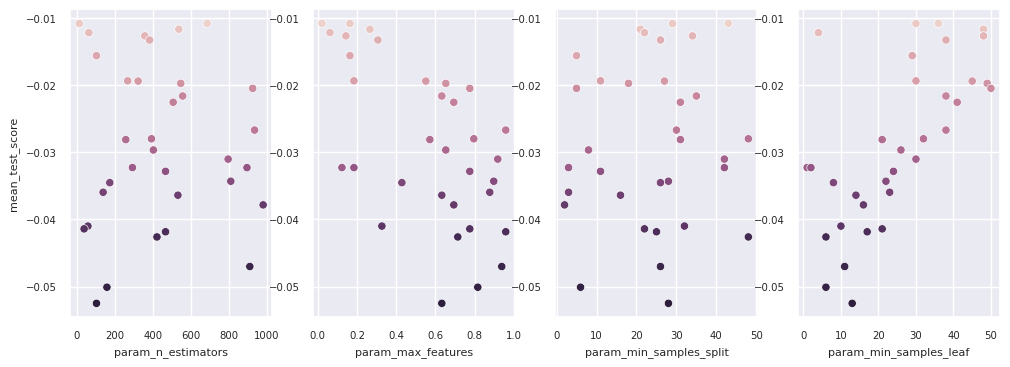


StandardScaler() RandomForestRegressor(max_features=0.021387755102040818, min_samples_leaf=36,
                      min_samples_split=43, n_estimators=686)


In [179]:
tmp = rs_viz(RandomForestRegressor(), work_df, {
    'n_estimators': [int(x) for x in np.linspace(10, 1000, 200)],    
    'max_features': [float(x) for x in np.linspace(0.001, 1, 50)],
    'min_samples_split': [int(x) for x in np.linspace(2, 50, 100)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 50, 100)]
                                                   },
             transformer=StandardScaler(), ncols=4)

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print()
print(*tmp[0]['transf'], *tmp[0]['params'])

In [180]:
GSCV = GridSearchCV(RandomForestRegressor(), {
    'n_estimators': [800, 980, 1200],
    'max_features': [0.01, 0.021, 0.03],
    'min_samples_split': [0.5, 2],
    'min_samples_leaf': [11, 13],
    },
    cv=3, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(work_df,
                                            transformer=StandardScaler())
GSCV.fit(X_train, y_train)

tmp = est(' GrdSearch', GSCV.best_estimator_, work_df,
          transformer=StandardScaler())
est_df = pd.concat([est_df, tmp ], ignore_index=True)

print(*tmp['transf'], *tmp['params'])
print(est_df.drop(['params', 'transf', 'MSE'], axis=1).sort_values(by='r2',
                                                            ascending=False))

StandardScaler() RandomForestRegressor(max_features=0.03, min_samples_leaf=13, n_estimators=1200)
                                                          note        r2       MAE
0  1023 StandardScaler() RandomForestRegressor(max_features... -0.019637  2.562022
1  1023 StandardScaler() RandomForestRegressor(max_features... -0.025448  2.567021


### SVR
* kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’ Указывает тип ядра, который будет использоваться в алгоритме. Он должен быть одним из «линейных», «полигональных», «rbf», «сигмоидальных», «предварительно вычисленных» или вызываемых.

* degree int, default=3 Степень полиномиальной функции ядра («поли»). Игнорируется всеми другими ядрами.

* gamma {‘scale’, ‘auto’} or float, default=’scale’ Коэффициент ядра для «rbf», «poly» и «sigmoid». Eсли передается gamma='scale' (по умолчанию), то в качестве значения гаммы используется 1 / (n_features * X.var ()), если «авто», использует 1 / n_features.

* coef0 float, default=0.0 Независимый член в функции ядра. Это имеет значение только в «поли» и «сигмовидной».

* tol float, default=1e-3 Толерантность к критерию остановки.

* C float, default=1.0 Параметр регуляризации. Сила регуляризации обратно пропорциональна C. Должна быть строго положительной. Штраф представляет собой квадратичный штраф l2.

* epsilon float, default=0.1 Эпсилон в модели Эпсилон-СВР. Он определяет эпсилон-трубку, в пределах которой нет штрафных санкций в функции потери тренировки с очками, предсказанными на расстоянии эпсилон от фактического значения.

* shrinking bool, default=True Использовать ли эвристику сжатия.

* cache_size float, default=200 размер кэша ядра (в мегабайтах).

* verbose bool, default=False Включить многословный вывод.Обратите внимание,что эта настройка использует преимущества настройки времени выполнения каждого процесса в libsvm,которая,если она включена,может работать некорректно в многопоточном контексте.

* max_iter int, default=-1 Жесткий лимит на итерации внутри решателя,или -1 без ограничения.

In [181]:
SVR().get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

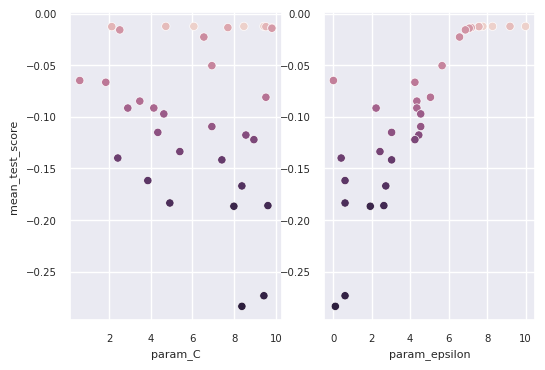


StandardScaler() SVR(C=8.4646, epsilon=7.778)


In [182]:
tmp = rs_viz(SVR(), clean_df, {
    'C': [round(x, 4) for x in np.linspace(0.5, 10, 100)],
    'epsilon': [round(x, 4) for x in np.linspace(0.001, 10, 100)],
    #'kernel': ['rbf'],
    #'gamma': ['scale']
    #[round(x, 3) for x in np.linspace(start = 0.001, stop = 0.999, num = 5)]
    },
    ncols=2, transformer=StandardScaler())

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print()
print(*tmp[0]['transf'], *tmp[0]['params'])

In [183]:
GSCV = GridSearchCV(SVR(), {
    'C': [0.25, 0.56, 0.75],
    'epsilon': [0.0001, 0.001, 0.005]
    },
    cv=10, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(clean_df,
                                            transformer=StandardScaler())
GSCV.fit(X_train, y_train)

tmp = est(' GrdSearch', GSCV.best_estimator_, clean_df,
          transformer=StandardScaler())
est_df = pd.concat([est_df, tmp ], ignore_index=True)

print(*tmp['transf'], *tmp['params'])
print(est_df.drop(['params', 'transf', 'MSE'], axis=1).sort_values(by='r2',
                                                            ascending=False))

StandardScaler() SVR(C=0.25, epsilon=0.0001)
                                                          note        r2       MAE
3   921 StandardScaler() SVR(C=0.25, epsilon=0.0001) GrdSearch  0.013171  2.434014
2  921 StandardScaler() SVR(C=8.4646, epsilon=7.778) RndSearch -0.014889  2.468936
0  1023 StandardScaler() RandomForestRegressor(max_features... -0.019637  2.562022
1  1023 StandardScaler() RandomForestRegressor(max_features... -0.025448  2.567021


###  GradientBoostingRegressor
* learning_rate : float, optional (default=0.1) ключевой для настройки параметр
* n_estimators: int (default=100) Количество «boosting stages» при обучении модели градиентного бустинга
* max_depth: integer, optional (default=3) Максимальная глубина отдельных регрессионных оценок. Максимальная глубина ограничивает количество узлов в дереве.
* criterion: string, optional (default=«friedman_mse») Функция измерения качества разделения. Поддерживаемые критерии: «friedman_mse» для среднеквадратичной ошибки с оценкой улучшения по Фридману, «mse» для среднеквадратичной ошибки и «mae» для средней абсолютной ошибки. Значение по умолчанию «friedman_mse», как правило, является лучшим, поскольку в некоторых случаях оно может обеспечить лучшее приближение.
* min_samples_split: int, float, optional (default=2) Минимальное количество примеров, необходимое для продолжения достраивания дерева в данной вершине при обучении. Попробуем изменить его.
* min_samples_leaf: int, float, optional (default=1) Минимальное количество примеров, которое может находиться в листе дерева после обучения. Увеличение этого параметра снижает качество предсказания на тренировочной выборке (т. к. при меньшем значении деревья, составляющие ансамбль в большей степени подстраиваются под каждый конкретный пример из обучающей выборки) и, если повезет, повышает качество на валидационной. То есть, по крайней мере теоретически, помогает бороться с переобучением.
* min_weight_fraction_leaf: float, optional (default=0.) Минимальная часть примеров, необходимая для формирования листа. По умолчанию их количество равно нулю, то есть не задает никакого ограничения. По идее, увеличение значения этого параметра должно препятствовать переобучению, подобно параметру mean_samples_leaf.

In [184]:
gbr = make_pipeline(StandardScaler(), GradientBoostingRegressor())

In [185]:
GradientBoostingRegressor().get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

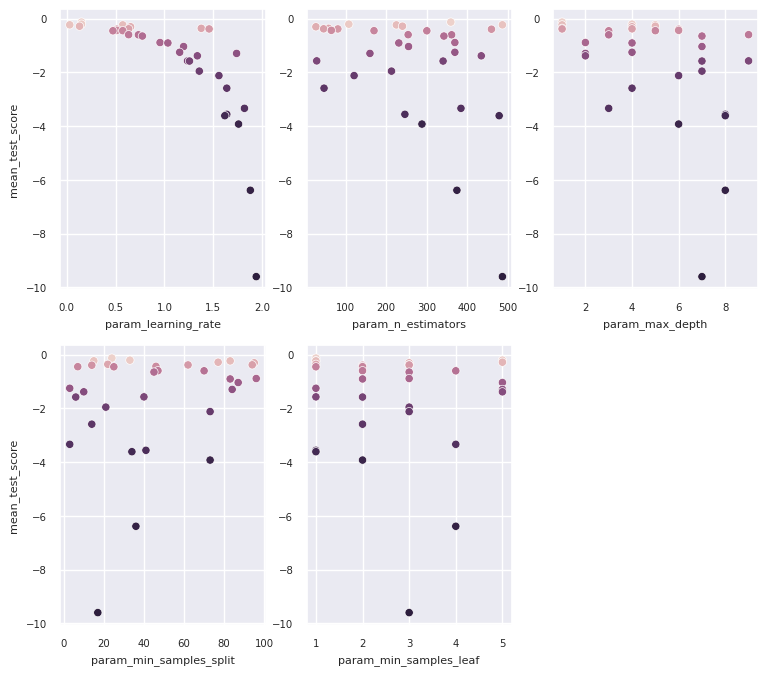


MinMaxScaler() GradientBoostingRegressor(learning_rate=0.1507, max_depth=1,
                          min_samples_split=24, n_estimators=359)


In [186]:
tmp = rs_viz(GradientBoostingRegressor(), work_df,
    {
    'learning_rate': [
        round(x, 4) for x in np.linspace(0.01, 2, 100)],
    'n_estimators': [
        int(x) for x in np.linspace(10, 500, 490)],
    'max_depth': [
        int(x) for x in np.linspace(1, 10, 10)],
    'min_samples_split': [
        int(x) for x in np.linspace(2, 100, 100)],
    'min_samples_leaf': [
        int(x) for x in np.linspace(1, 5, 5)],
    },
    ncols=3, transformer=MinMaxScaler())

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print()
print(*tmp[0]['transf'], *tmp[0]['params'])

### подбор по сетке

In [187]:
GSCV = GridSearchCV(GradientBoostingRegressor(), {
    'learning_rate': [0.01, 0.1507],
    'n_estimators': [80, 359],
    'max_depth': [1],
    'min_samples_split': [24],
    'min_samples_leaf': [1],
    },
    cv=3, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(work_df)
GSCV.fit(X_train, y_train)

tmp = est(' GrdSearch', GSCV.best_estimator_, work_df,
          transformer=StandardScaler())
est_df = pd.concat([est_df, tmp ], ignore_index=True)

print(*tmp['transf'], *tmp['params'])
print(est_df.drop(['params', 'transf', 'MSE'], axis=1).sort_values(by='r2',
                                                            ascending=False))

StandardScaler() GradientBoostingRegressor(learning_rate=0.01, max_depth=1, min_samples_split=24,
                          n_estimators=80)
                                                          note        r2       MAE
3   921 StandardScaler() SVR(C=0.25, epsilon=0.0001) GrdSearch  0.013171  2.434014
2  921 StandardScaler() SVR(C=8.4646, epsilon=7.778) RndSearch -0.014889  2.468936
5  1023 StandardScaler() GradientBoostingRegressor(learning... -0.018001  2.562353
0  1023 StandardScaler() RandomForestRegressor(max_features... -0.019637  2.562022
1  1023 StandardScaler() RandomForestRegressor(max_features... -0.025448  2.567021
4  1023 MinMaxScaler() GradientBoostingRegressor(learning_r... -0.099070  2.613470


### Lasso


In [188]:
Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

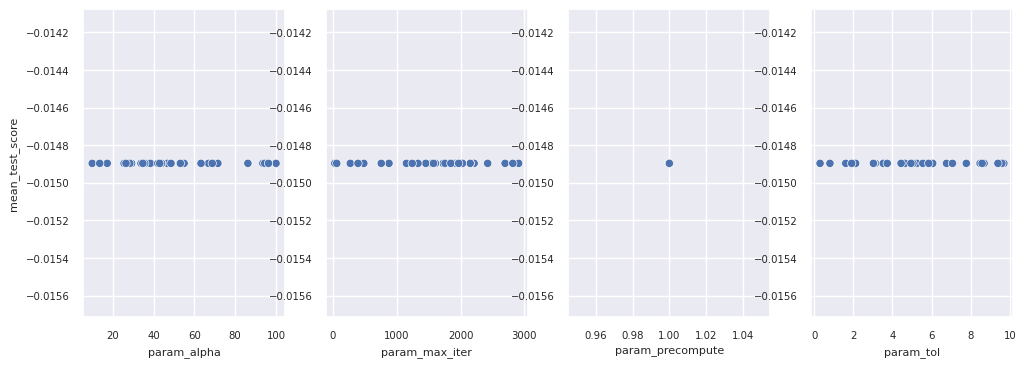


MinMaxScaler() Lasso(alpha=9.9192, max_iter=273, precompute=True, tol=6.7676799999999995)


In [189]:
tmp = rs_viz(Lasso(), work_df,
    {
    'alpha': [round(x, 4) for x in np.linspace(9, 100, 100)],       
    #'fit_intercept': [False, True],
    'max_iter': [int(x) for x in np.linspace(1, 3000, 100)],
    #'positive': [False, True],
    'precompute': [True],
    'tol': [float(x) for x in np.linspace(0.00001, 10, 100)]
    }, transformer=MinMaxScaler(),
    ncols=4)

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print()
print(*tmp[0]['transf'], *tmp[0]['params'])

In [190]:
GSCV = GridSearchCV(Lasso(), {
    'alpha': [0.1, 0.4],
    'max_iter': [2000, 2250],
    'tol': [0.00068, 7.68]
    },
    cv=10, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(work_df, transformer=MinMaxScaler())
GSCV.fit(X_train, y_train)

tmp = est(' GrdSearch', GSCV.best_estimator_, work_df,
          transformer=MinMaxScaler())

est_df = pd.concat([est_df, tmp], ignore_index=True)
est_df.drop('params', axis=1).sort_values(by='r2', ascending=False)

print(*tmp['transf'], *tmp['params'])
print(est_df.drop(['params', 'transf', 'MSE'], axis=1).sort_values(by='r2',
                                                            ascending=False))

MinMaxScaler() Lasso(alpha=0.1, max_iter=2000, tol=0.00068)
                                                          note        r2       MAE
3   921 StandardScaler() SVR(C=0.25, epsilon=0.0001) GrdSearch  0.013171  2.434014
2  921 StandardScaler() SVR(C=8.4646, epsilon=7.778) RndSearch -0.014889  2.468936
6  1023 MinMaxScaler() Lasso(alpha=9.9192, max_iter=273, pr... -0.016426  2.556417
7  1023 MinMaxScaler() Lasso(alpha=0.1, max_iter=2000, tol=... -0.016426  2.556417
5  1023 StandardScaler() GradientBoostingRegressor(learning... -0.018001  2.562353
0  1023 StandardScaler() RandomForestRegressor(max_features... -0.019637  2.562022
1  1023 StandardScaler() RandomForestRegressor(max_features... -0.025448  2.567021
4  1023 MinMaxScaler() GradientBoostingRegressor(learning_r... -0.099070  2.613470


In [191]:
best1 = pd.concat([est_df, est_default]).sort_values(by='r2', ascending=False, ignore_index=True)

In [192]:
best1

,note,r2,MAE,MSE,params,transf
0,"921 StandardScaler() SVR(C=0.25, epsilon=0.0001) GrdSearch",0.013171,2.434014,8.912916,"SVR(C=0.25, epsilon=0.0001)",StandardScaler()
1,921 MinMaxScaler() SVR() default,0.001891,2.466912,9.014792,SVR(),MinMaxScaler()
2,921 Normalizer() SVR() default,-0.000669,2.453712,9.037911,SVR(),Normalizer()
3,921 None SVR() default,-0.001116,2.455252,9.041949,SVR(),None
4,921 StandardScaler() SVR() default,-0.002533,2.462676,9.054745,SVR(),StandardScaler()
5,921 None Lasso() default,-0.003707,2.460869,9.065354,Lasso(),None
6,921 Normalizer() Lasso() default,-0.006772,2.460820,9.093036,Lasso(),Normalizer()
7,921 MinMaxScaler() Lasso() default,-0.006772,2.460820,9.093036,Lasso(),MinMaxScaler()
8,921 StandardScaler() Lasso() default,-0.006772,2.460820,9.093036,Lasso(),StandardScaler()
9,921 MinMaxScaler() LinearRegression() default,-0.012262,2.471668,9.142619,LinearRegression(),MinMaxScaler()


In [193]:
best_model = best1.sort_values(by='r2', ascending=False)[:1].iloc[0, 4]
best_model

SVR(C=0.25, epsilon=0.0001)

In [194]:
best_transf = best1.sort_values(by='r2', ascending=False)[:1].iloc[0, 5]
best_transf

StandardScaler()

In [195]:
pl_model = make_pipeline(best_transf, best_model)
pl_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.25, epsilon=0.0001))])

In [196]:
cur_target_cols

['Модуль упругости при растяжении, ГПа']

In [197]:
targ_cols

['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']

In [211]:
y = clean_df[cur_target_cols]
X = clean_df.drop(targ_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 42
    )
pl_model.fit(X_train, y_train)

y_prtr = pl_model.predict(X_train)
y_prts = pl_model.predict(X_test)

print(f'     r2 на тестовой: {r2_score(y_test, y_prts)}')
print(f'r2 на тренировочной: {r2_score(y_train, y_prtr)}')

     r2 на тестовой: 0.013032383991715468
r2 на тренировочной: 0.06668528579170574


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [212]:
dump(pl_model, 'Модуль упругости при растяжении, ГПа.joblib')

['Модуль упругости при растяжении, ГПа.joblib']

In [213]:
model1=load('Модуль упругости при растяжении, ГПа.joblib')
y_prtr1 = model1.predict(X_train)
y_prts1 = model1.predict(X_test)

print(f'     r2 на тестовой: {r2_score(y_test, y_prts1)}')
print(f'r2 на тренировочной: {r2_score(y_train, y_prtr1)}')

     r2 на тестовой: 0.013032383991715468
r2 на тренировочной: 0.06668528579170574


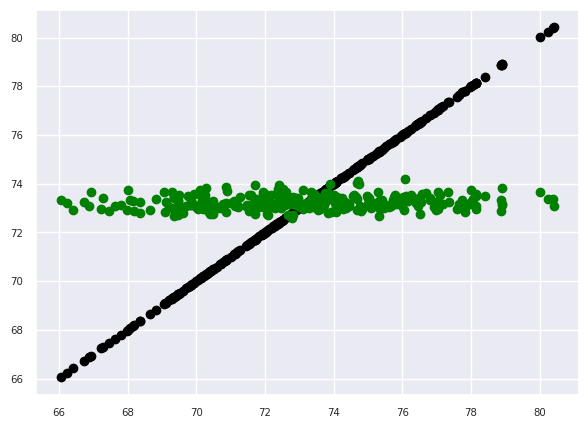

In [214]:
plt.figure(figsize = (7, 5))
plt.scatter(y_test, y_test, color='black')
plt.scatter(y_test, y_prts, color='green')

plt.show()
print()

## Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель.

model.add(Dense(1,
                activation='linear',
                bias_initializer='glorot_normal',
                kernel_initializer='glorot_normal'))

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

In [48]:
pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.6 MB/s eta 0:00:00


In [49]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Dense, Dropout, Normalization #  слой
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from keras.metrics import RootMeanSquaredError

<ipython-input-49-07bee81604ec>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization


### Проверяю входные

In [50]:
cur_target_cols

['Соотношение матрица-наполнитель']

In [51]:
targ_cols

['Соотношение матрица-наполнитель']

In [52]:
clean_df.shape

(921, 13)

In [53]:
y = np.array(clean_df[cur_target_cols])
X = np.array(clean_df.drop(targ_cols, axis=1))


In [54]:
X= MinMaxScaler().fit_transform(X)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 42
    )

In [56]:
X_train.shape

(644, 12)

In [57]:
y_train.shape

(644, 1)

### функция создания нейронной сети

In [58]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu',
                                                        'sigmoid',
                                                        'tanh',
                                                        'elu',
                                                        'selu'])    
    model.add(Dense(units=hp.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=512,    # минимальное количество нейронов - 128
                                   max_value=1024,   # максимальное количество - 1024
                                   step=32),
                    input_dim=X_train.shape[1],
                    activation=activation_choice))
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=128,   
                                   max_value=600,   
                                   step=32),
                    activation=activation_choice))   
    model.add(Dense(y_train.shape[1]))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

### tuner

In [65]:
tuner = RandomSearch(
    build_model,                 # функция создания модели
    objective='val_mean_squared_error',# метрика, которую нужно оптимизировать - 
                         # доля правильных ответов на проверочном наборе данных
    max_trials=50,               # максимальное количество запусков обучения 
    directory='test_directory'   # каталог, куда сохраняются обученные сети  
    )

### подбор гиперпараметров

Пространство поиска

In [60]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 600, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'SGD'], 'ordered': False}


Подбор

In [66]:
tuner.search(X_train,                  # Данные для обучения
             y_train,                  # Правильные ответы
             batch_size=30,            # Размер мини-выборки
             epochs=100,                # Количество эпох обучения 
             validation_split=0.3,     # Часть данных, которая будет использоваться для проверки
             )

Trial 10 Complete [00h 00m 06s]
val_mean_squared_error: 0.772075355052948

Best val_mean_squared_error So Far: 0.7654126286506653
Total elapsed time: 00h 01m 03s


### Лучшие модели

In [67]:
tuner.results_summary()

Results summary
Results in test_directory2/untitled_project
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 07 summary
Hyperparameters:
activation: elu
units_input: 832
units_hidden: 128
optimizer: rmsprop
Score: 0.7654126286506653

Trial 00 summary
Hyperparameters:
activation: relu
units_input: 672
units_hidden: 512
optimizer: SGD
Score: 0.7699613571166992

Trial 04 summary
Hyperparameters:
activation: sigmoid
units_input: 576
units_hidden: 480
optimizer: adam
Score: 0.7706901431083679

Trial 08 summary
Hyperparameters:
activation: sigmoid
units_input: 992
units_hidden: 192
optimizer: adam
Score: 0.770785927772522

Trial 01 summary
Hyperparameters:
activation: sigmoid
units_input: 544
units_hidden: 320
optimizer: SGD
Score: 0.7708893418312073

Trial 09 summary
Hyperparameters:
activation: sigmoid
units_input: 736
units_hidden: 352
optimizer: rmsprop
Score: 0.772075355052948

Trial 02 summary
Hyperparameters:
activation: elu
units_input: 992
unit

Пять лучших моделей

In [68]:
models = tuner.get_best_models(num_models=5)

### Качество моделей на тестовых данных

In [104]:
for model in models:
  model.summary()
  model.evaluate(X_test, y_test)
  print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 832)               10816     
                                                                 
 dense_1 (Dense)             (None, 128)               106624    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 117,569
Trainable params: 117,569
Non-trainable params: 0
_________________________________________________________________
9/9 [==============================] - 0s 3ms/step - loss: 1608.4117 - mean_squared_error: 1608.4117

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 672)               8736 

### Окончательный выбор

In [105]:
model = models[2]

Информация о модели

In [123]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 576)               7488      
                                                                 
 dense_1 (Dense)             (None, 480)               276960    
                                                                 
 dense_2 (Dense)             (None, 1)                 481       
                                                                 
Total params: 284,929
Trainable params: 284,929
Non-trainable params: 0
_________________________________________________________________


In [124]:
model.get_compile_config()

{'optimizer': 'adam',
 'loss': 'mean_squared_error',
 'metrics': ['mean_squared_error'],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

Инициализация весов

In [116]:
wg = model.get_weights()

In [117]:

model.set_weights(
    #[np.random.uniform(0, 1, (i.shape)) for i in model.get_weights()]
    [np.random.sample(i.shape) for i in model.get_weights()]
    )

In [89]:
model.set_weights(wg())

Обучение

<Axes: >

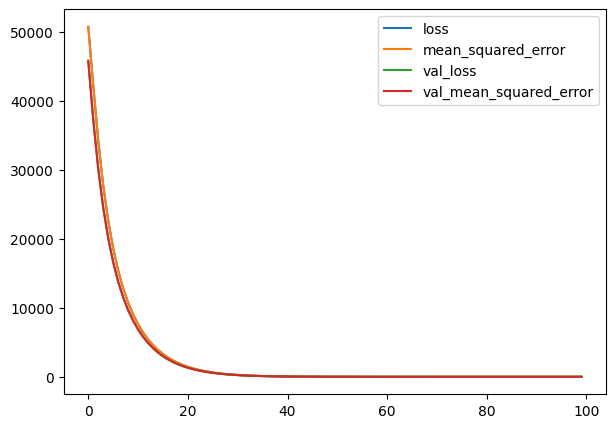

In [118]:
history = model.fit(X_train, y_train,
                    batch_size=60,
                    epochs=100,
                    verbose=0,
                    validation_split=0.3
                    )
pd.DataFrame(history.history).plot(figsize=(7, 5)) # метрики и функции потерь

Проверка на тестовой части

In [119]:
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [121]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 0.8057 - mean_squared_error: 0.8057


[0.8056550621986389, 0.8056550621986389]

In [122]:
model.evaluate(X_train, y_train)

21/21 [==============================] - 0s 2ms/step - loss: 0.8017 - mean_squared_error: 0.8017


[0.801701545715332, 0.801701545715332]

Неутешительная картинка

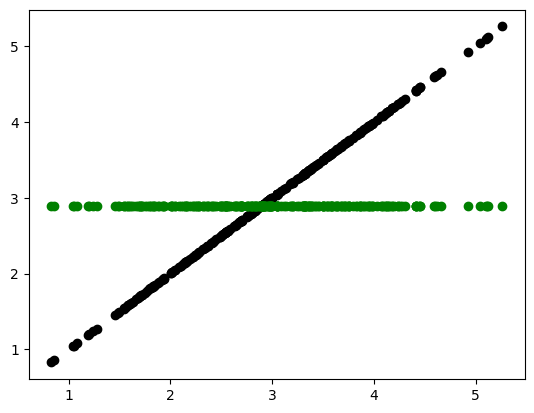

r2: -0.006402520664139821


In [120]:
#результат приближения нейросетью поверх исходной функции
plt.scatter(y_test, y_test, color='black')
plt.scatter(y_test, y_pred, color='green')
plt.show()
print('r2:', r2_score(y_test, y_pred))

### Сохранение модели

In [125]:
model.save('/content/drive/MyDrive/Temp/Соотношение матрица-наполнитель')

Проверка сохраненной

In [126]:
model1 = load_model('/content/drive/MyDrive/Temp/Соотношение матрица-наполнитель')

In [306]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [127]:
y_pred1 = model1.predict(X_test)

9/9 [==============================] - 0s 2ms/step


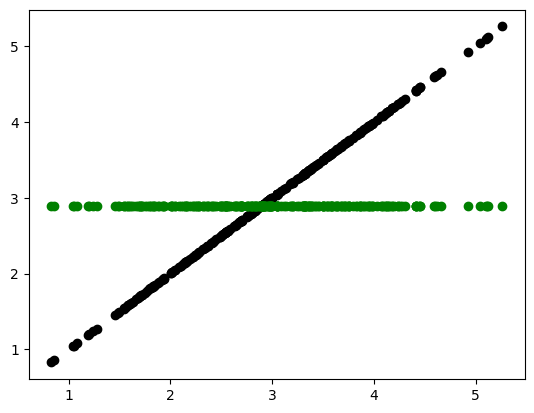

In [128]:
plt.scatter(y_test, y_test, color='black')
plt.scatter(y_test, y_pred1, color='green')
plt.show()
